Import necessary packets

In [50]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Separate training set and validation set.

In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [17]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


The dataset involves 60,000 training images and 10,000 testing images, the resolution is 28x28.

## Visualizing Data
To get a better understanding of the dataset, let's visualize some random images for each class from training and testing datasets.

In [18]:
def show_MNIST(labels, images, samples=8):
  numclass = 10
  classes = [str(i) for i in range(10)]
  for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in labels])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i, idx in enumerate(idxs):
      plt_idx = i * numclass + y + 1
      plt.subplot(samples, numclass, plt_idx)
      plt.imshow(images[idx], cmap='gray')
      plt.axis("off")
      if i == 0:
        plt.title(cls)

  plt.show()

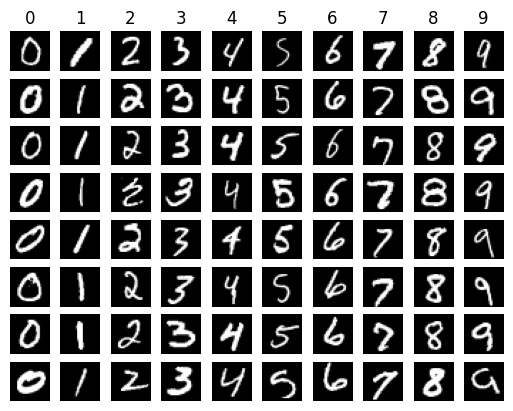

In [19]:
show_MNIST(y_train, X_train)

Let's have a look at the average of all the images of training and testing data.

In [20]:
def show_ave_MNIST(labels, images):
  item_type = "Digit"
  classes = [str(i) for i in range(10)]
  for y, cls in enumerate(classes):
    idxs = np.nonzero([i==y for i in labels])
    print(item_type, y, ":", len(idxs[0]), "images.")

In [21]:
show_ave_MNIST(y_train, X_train)

Digit 0 : 5923 images.
Digit 1 : 6742 images.
Digit 2 : 5958 images.
Digit 3 : 6131 images.
Digit 4 : 5842 images.
Digit 5 : 5421 images.
Digit 6 : 5918 images.
Digit 7 : 6265 images.
Digit 8 : 5851 images.
Digit 9 : 5949 images.


In [22]:
show_ave_MNIST(y_test, X_test)

Digit 0 : 980 images.
Digit 1 : 1135 images.
Digit 2 : 1032 images.
Digit 3 : 1010 images.
Digit 4 : 982 images.
Digit 5 : 892 images.
Digit 6 : 958 images.
Digit 7 : 1028 images.
Digit 8 : 974 images.
Digit 9 : 1009 images.


## K-Nearest Neighbor


In [23]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(n_neighbors=3)
kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

We will now try to classify a random image from the dataset using kNN classifier

In [25]:
print(kNN.predict(X_test[211].reshape(1, -1)))

[5]


To make sure that the output we got is correct, let's plot that image along with its label

Actual class of test image: 5


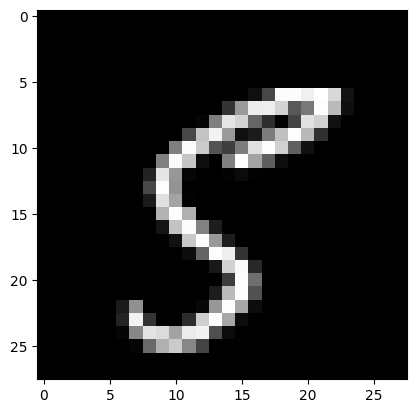

In [26]:
%matplotlib inline
print("Actual class of test image:", y_test[211])
plt.imshow(X_test[211].reshape((28, 28)), cmap='gray')

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, kNN.predict(X_test))

0.9705

With K-nearest neighbor algorithm, we have ~97% accuracy on this dataset.

## Naive-Bayes

If you are using google colab or other notebooks, please load files NaiveBayes.py and utils.py from github repository to the session

In [28]:
from NaiveBayes import *
from utils import *

In [29]:
print(X_train.shape)
temp_train_lbl = y_train.reshape(60000,1)
training_examples = np.hstack((X_train, temp_train_lbl))
print(training_examples.shape)

(60000, 784)
(60000, 785)


In [30]:
MNIST_dataset = Dataset(examples=training_examples, distance=manhattan_distance)

In [31]:
nb = NaiveBayesLearner(MNIST_dataset)

Let's make a prediction.

In [32]:
print(nb(X_test[15]))

0


To make sure we got correct output, let's plot the image along with it's label.

Actual class of test image: 5


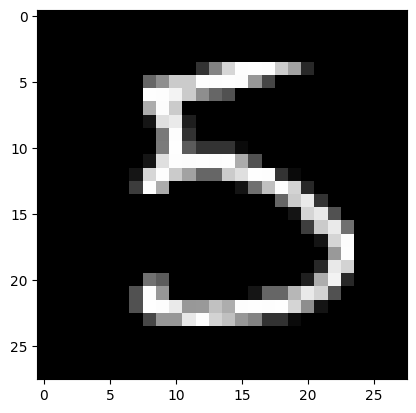

In [33]:
%matplotlib inline
print("Actual class of test image:", y_test[15])
plt.imshow(X_test[15].reshape((28, 28)), cmap='gray')

In [34]:
accuracy_score(y_test, [nb(test_img) for test_img in X_test])

0.2687

Because Naive Bayes is a generative model and it relies on the strong assumption that attributes are not dependent on each other. It seems that in this task, the assumption violated practice. Therefore, the result is bad.

## Neural Networks
Let's build a convolutional neural network

There are 10 categorical classes, therefore, we can use one hot encoding to transform the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes.

In [35]:
# baseline cnn model for mnist
import keras
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [36]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

### Prepare Pixel Data
The values of pixel for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255. Now, we normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves converting the data type to floats, then dividing the pixel values by 255.

In [37]:
def prep_pixels(train, test):
  # Convert from integer to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # Normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # Return normalized images
  return train_norm, test_norm

### Define Model

In this stage, we define a baseline convolutional neural network model for the problem.

The model comprises two primary components: the feature extraction frontend and the classifier backend. The feature extraction frontend includes convolutional and pooling layers, while the classifier backend is responsible for making predictions.

The convolutional layer has a small filter size of (3,3) and 32 filters, followed by a max pooling layer. Next, two convolutional has filter size of (3,3) and 64 filter, followed by a max pooling layer. The resulting filter maps are then flattened to create feature inputs for the classifier.

Softmax activation function is used for output becausethe problem is a multi-class classification task with 10 classes. Between the feature extractor and the output layer, we add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

In [38]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [39]:
model = define_model()

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0

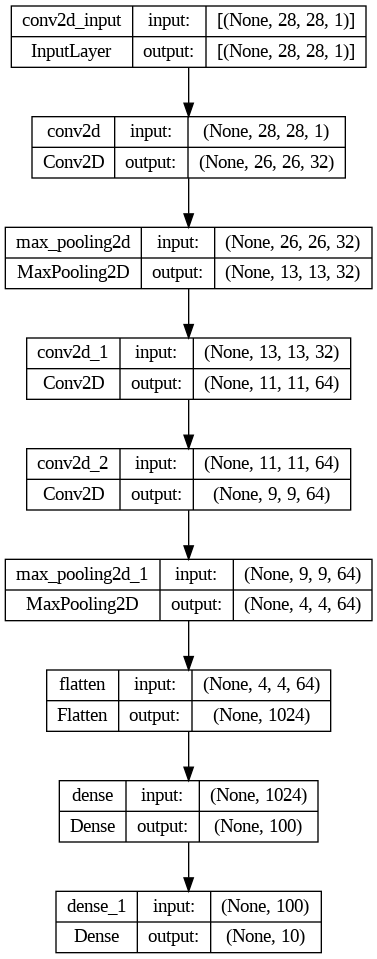

In [41]:
keras.utils.plot_model(model, show_shapes=True)

### Training and Evaluation
Let's train and evaluate the model with the test set. Then, choose proper hyperparamater.

In [42]:
def evaluate_model(dataX, dataY, n_folds=5):
  scores, records = [], []
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    record = model.fit(trainX, trainY, epochs=25, batch_size=32, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    records.append(record)
  return scores, records

In [46]:
def summarize_diagnostics(records):
  for i in range(len(records)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(records[i].history['loss'], color='blue', label='train')
    plt.plot(records[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(records[i].history['accuracy'], color='blue', label='train')
    plt.plot(records[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [44]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

> 99.158
> 99.133
> 99.017
> 99.308
> 99.225


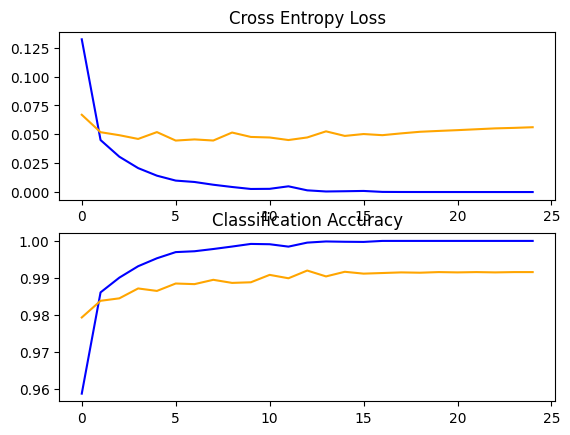

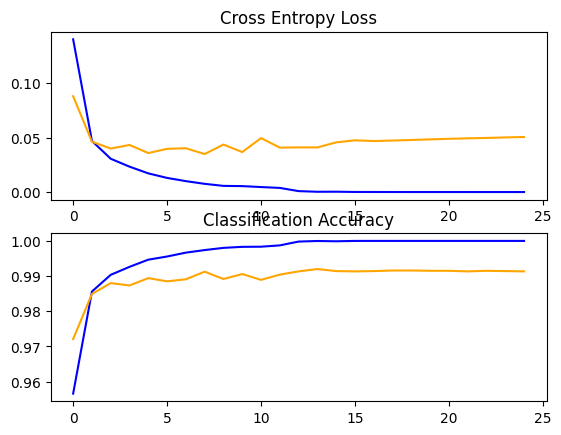

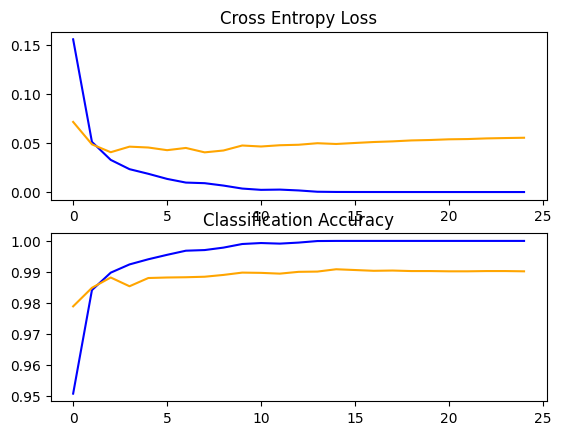

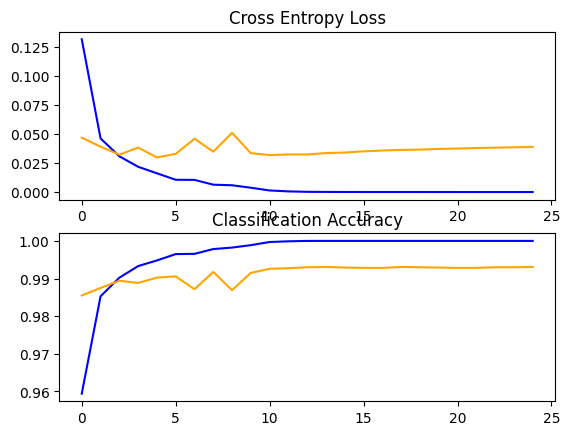

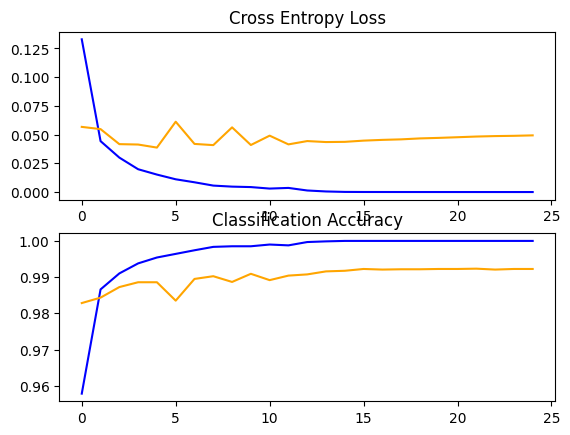

Accuracy: mean=99.168 std=0.097, n=5


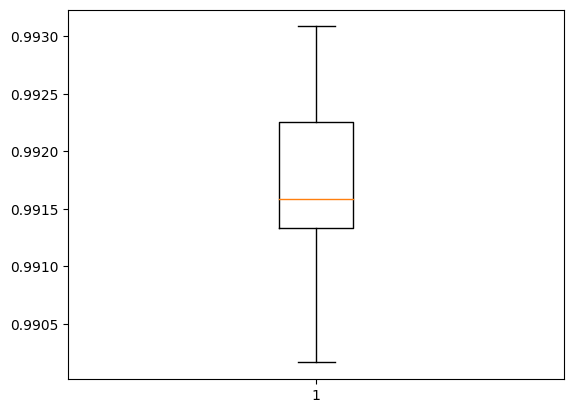

In [47]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # evaluate model
  scores, records = evaluate_model(trainX, trainY)
  # learning curves
  summarize_diagnostics(records)
  # Summarize estimated performance
  summarize_performance(scores)

run_test_harness()

After all, let's predict one testing image

In [48]:
trainX, trainy, testX, testy = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
model = define_model()
model.fit(trainX, trainy, epochs=25, batch_size=32, verbose=0)
model.save('final_model.h5')
# Evaluate model on test dataset
_, acc = model.evaluate(testX, testy, verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


> 99.290


We got an accuracy of 99.29% which is a good result. It is estimated that humans have an error rate of about 0.2% on this problem.

In [64]:
[np.argmax(model.predict(testx.reshape[1,28,28,1])) for testx in testX].shape

TypeError: 'builtin_function_or_method' object is not subscriptable

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step


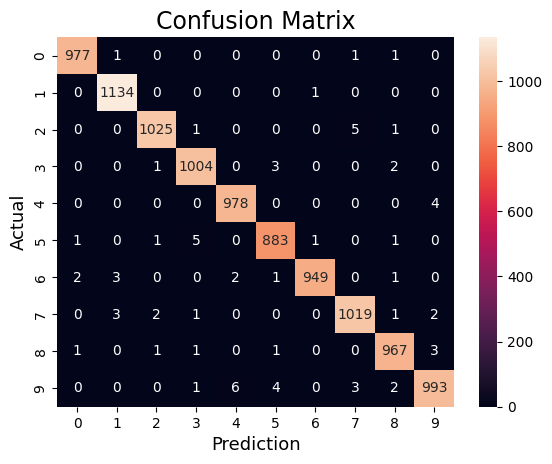

In [65]:
cm = confusion_matrix(y_test,[np.argmax(model.predict(testx.reshape(1,28,28,1))) for testx in testX])
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

As we can see, the 9 digit is the most wrong digit.

In [67]:
print(classification_report(y_test,[np.argmax(model.predict(testx.reshape(1,28,28,1))) for testx in testX]))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

